In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


naver.me/5s9YNMcH  --> data-02-stock_daily.csv
Open(시작가), High(최고가), Low(최저가), Vol(거래량), Close(종가)

In [3]:
import numpy as np
xy = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/data-02-stock_daily.csv', delimiter=",")

In [4]:
xy[:2]

array([[8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02]])

In [5]:
#train, test split
seq_length = 7
train_size = int(len(xy)*0.7)
train_set = xy[:train_size]
test_set = xy[train_size - seq_length:]
print(train_set.shape, test_set.shape)

(512, 5) (227, 5)


In [6]:
def minmax_scaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0)-np.min(data,0)
  return numerator / (denominator + 1e-7)

In [7]:
#scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [8]:
train_set[:3]

array([[0.97125436, 0.97337226, 1.        , 0.06773081, 0.98742313],
       [0.95353593, 0.95651845, 0.978622  , 0.10064206, 0.97616367],
       [0.94382833, 0.94502159, 0.97008016, 0.07092699, 0.96390035]])

In [9]:
def build_dataset(time_series_data, seq_length):
  data_X = []; data_y = []
  for i in range(0, len(time_series_data)-seq_length):
    x_ = time_series_data[i: i + seq_length, :]
    y_ = time_series_data[i+seq_length, [-1]]
    data_X.append(x_); data_y.append(y_)
  return np.array(data_X), np.array(data_y)


In [10]:
train_X, train_y = build_dataset(train_set, seq_length)
test_X, test_y = build_dataset(test_set, seq_length)


In [11]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [12]:
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [13]:
train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.FloatTensor(train_y)
test_X_tensor = torch.FloatTensor(test_X)
test_y_tensor = torch.FloatTensor(test_y)

In [14]:
class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, 
                             batch_first=True)
    self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [15]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [16]:
# training!
for i in range(iterations):
  optimizer.zero_grad()
  outputs = net(train_X_tensor)
  loss = criterion(outputs, train_y_tensor)
  loss.backward()
  optimizer.step()
  print(i, loss.item())

0 0.16159194707870483
1 0.11185331642627716
2 0.0742645114660263
3 0.05486828088760376
4 0.055594976991415024
5 0.06332159042358398
6 0.06295397877693176
7 0.05432845279574394
8 0.043394796550273895
9 0.034790702164173126
10 0.030020907521247864
11 0.028253834694623947
12 0.027758603915572166
13 0.02694319374859333
14 0.02484317682683468
15 0.021250354126095772
16 0.016672393307089806
17 0.012205637991428375
18 0.009221545420587063
19 0.008586487732827663
20 0.00939863920211792
21 0.009191932156682014
22 0.007026667706668377
23 0.004339246544986963
24 0.002961046528071165
25 0.0033983748871833086
26 0.004521273076534271
27 0.004842123482376337
28 0.00398224638774991
29 0.0027947938069701195
30 0.0024156146682798862
31 0.00309199676848948
32 0.003884978126734495
33 0.0038564049173146486
34 0.0031374788377434015
35 0.0025079133920371532
36 0.002433926099911332
37 0.0027149736415594816
38 0.0028678709641098976
39 0.0026477088686078787
40 0.0021915885154157877
41 0.001805682317353785
42 0.

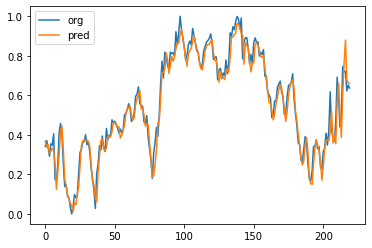

In [17]:
plt.plot(test_y)
plt.plot(net(test_X_tensor).data.numpy())
plt.legend(['org', 'pred'])
plt.show()